In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.layers import LayerNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import CategoricalCrossentropy

In [2]:
normal_path = 'OralCancer/Normal'
oscc_path = 'OralCancer/OSCC'

In [3]:
def load_images(folder_path, label, image_size=(128, 128)):
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load Normal and OSCC images
images, labels = [], []
normal_images, normal_labels = load_images(normal_path, label=0)
oscc_images, oscc_labels = load_images(oscc_path, label=1)

In [88]:
print(f"Total images loaded: {len(images)}")

Total images loaded: 4946


In [4]:
images = np.concatenate((normal_images, oscc_images), axis=0)
labels = np.concatenate((normal_labels, oscc_labels), axis=0)

In [5]:
# Normalize images
images = images / 255.0
# One-hot encode labels
labels = to_categorical(labels, num_classes=2)

In [ ]:
label_counts = np.unique(labels, return_counts=True)
class_names = ['Normal', 'OSCC']

ax = sns.barplot(x=class_names, y=label_counts[1])
for i, count in enumerate(label_counts[1]):
    ax.text(i, count + 0.05, str(count), ha='center', va='bottom', fontsize=12)
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.xlabel("Class")
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

# Indices for both classes
normal_indices = np.where(labels == 0)[0]
oscc_indices = np.where(labels == 1)[0]

# Display 5 images from each class
for i in range(5):
    # Plot Normal images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[normal_indices[i]])
    plt.title(f"Label: Normal")
    plt.axis("off")

    # Plot OSCC images
    plt.subplot(2, 5, i + 6)
    plt.imshow(images[oscc_indices[i]])
    plt.title(f"Label: OSCC")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=97, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=97, stratify=y_temp)

In [7]:
model = Sequential([
    # Convolutional Block 1
    Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate= 0.3, seed= 123),

    # Convolutional Block 2
    Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate= 0.3, seed= 123),

    # MaxPooling (Final Pooling Layer)
    MaxPooling2D(pool_size=2, strides=2),
    # Flatten the output for Dense Layers
    Flatten(),

    # Dense Layers
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)       

In [8]:
print(X_train.shape)
print(y_train.shape)

(3462, 128, 128, 3)
(3462, 2)


In [47]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('kan_oralcancer_model1.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
55/55 [==============================] - 13s 222ms/step - loss: 0.3934 - accuracy: 0.8795 - val_loss: 1.0713 - val_accuracy: 0.6549
Epoch 2/100
55/55 [==============================] - 12s 219ms/step - loss: 0.4340 - accuracy: 0.8408 - val_loss: 0.6883 - val_accuracy: 0.7626
Epoch 3/100
55/55 [==============================] - 12s 218ms/step - loss: 0.4146 - accuracy: 0.8599 - val_loss: 0.6532 - val_accuracy: 0.7757
Epoch 4/100
55/55 [==============================] - 12s 218ms/step - loss: 0.4108 - accuracy: 0.8637 - val_loss: 0.6848 - val_accuracy: 0.7404
Epoch 5/100
55/55 [==============================] - 12s 219ms/step - loss: 0.4050 - accuracy: 0.8712 - val_loss: 0.8230 - val_accuracy: 0.7173
Epoch 6/100
55/55 [==============================] - 12s 218ms/step - loss: 0.4135 - accuracy: 0.8628 - val_loss: 0.5596 - val_accuracy: 0.7948
Epoch 7/100
55/55 [==============================] - 12s 218ms/step - loss: 0.4941 - accuracy: 0.8267 - val_loss: 2.7589 - val_accuracy:

In [7]:
#Load saved model

from tensorflow.keras.models import load_model
model = load_model('kan_oralcancer_model1.keras')
model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_2 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_3 (Bat  (None, 64, 64, 64)    

In [8]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



16/16 [==============================] - 1s 31ms/step - loss: 0.3097 - accuracy: 0.9245
Test Loss: 0.30967360734939575
Test Accuracy: 0.9244897961616516


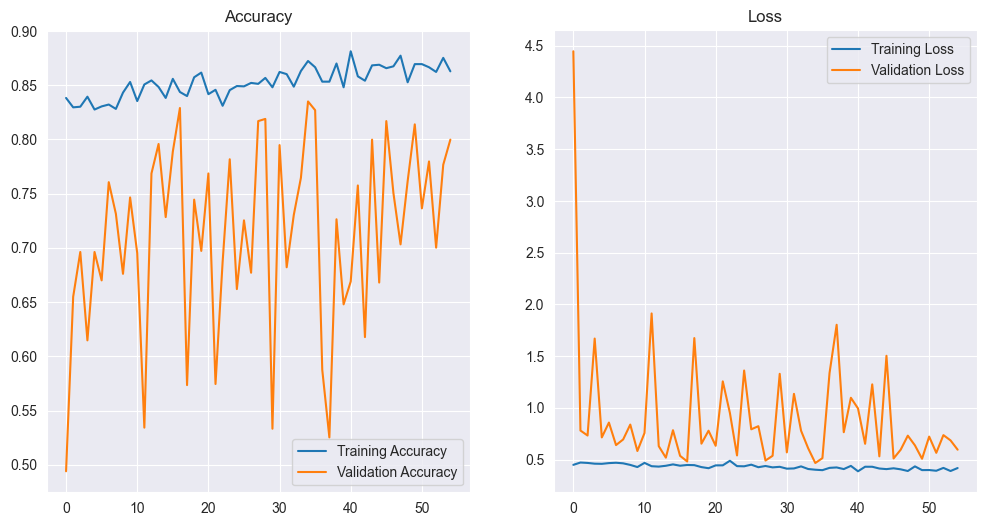

In [44]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

16/16 [==============================] - 1s 30ms/step


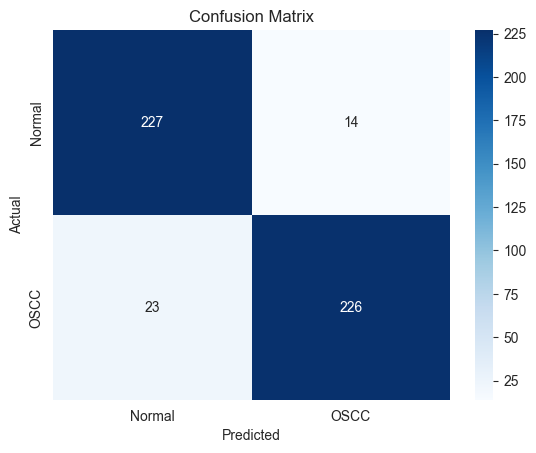

In [9]:
# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'OSCC']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
tn, fp, fn, tp = cm.ravel()
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = tn / (tn + fp)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"True Positive: {tp}")
print(f"True Negative: {tn}")
print(f"False Positive: {fp}")
print(f"False Negative: {fn}")

Accuracy: 0.9245
Precision: 0.9417
Recall (Sensitivity): 0.9076
Specificity: 0.9419
F1 Score: 0.9243
True Positive: 226
True Negative: 227
False Positive: 14
False Negative: 23


## ResNet

In [35]:
# Load the ResNet50 model pre-trained on ImageNet
# Exclude the top fully connected layers using include_top=False
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the pre-trained layers to retain ImageNet weights
base_model.trainable = False

# Create a new model on top of the ResNet50 base
model = Sequential([
    base_model,
    MaxPooling2D(pool_size=2, strides=2),  # Flatten the feature maps to a vector
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Add a dense layer with 256 units
    Dropout(0.5),  # Dropout for regularization
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.01),
    loss=CategoricalCrossentropy(),      # Use categorical crossentropy for binary classification
    metrics=['accuracy']                 # Track accuracy during training
)

# Display the model summary
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 2048)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 2)                 514       
                                                      

In [36]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
55/55 [==============================] - 37s 628ms/step - loss: 1.5986 - accuracy: 0.5092 - val_loss: 0.8722 - val_accuracy: 0.5070
Epoch 2/10
55/55 [==============================] - 35s 634ms/step - loss: 0.7602 - accuracy: 0.5159 - val_loss: 0.7348 - val_accuracy: 0.5241
Epoch 3/10
55/55 [==============================] - 34s 614ms/step - loss: 0.7320 - accuracy: 0.5113 - val_loss: 0.7244 - val_accuracy: 0.5342
Epoch 4/10
55/55 [==============================] - 36s 657ms/step - loss: 0.7227 - accuracy: 0.5090 - val_loss: 0.7193 - val_accuracy: 0.4930
Epoch 5/10
55/55 [==============================] - 34s 622ms/step - loss: 0.7174 - accuracy: 0.5061 - val_loss: 0.7138 - val_accuracy: 0.5070
Epoch 6/10
55/55 [==============================] - 33s 599ms/step - loss: 0.7128 - accuracy: 0.5084 - val_loss: 0.7100 - val_accuracy: 0.5070
Epoch 7/10
55/55 [==============================] - 32s 589ms/step - loss: 0.7087 - accuracy: 0.5136 - val_loss: 0.7075 - val_accuracy: 0.4930

In [37]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 [==============================] - 4s 225ms/step - loss: 0.7019 - accuracy: 0.5082
Test Loss: 0.7018794417381287
Test Accuracy: 0.5081632733345032


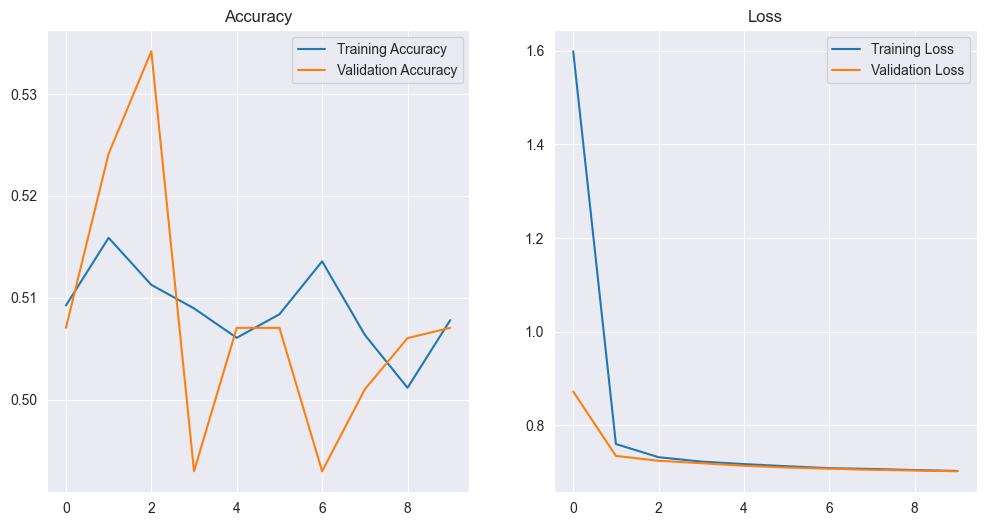

In [38]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_oralcancer_model.keras', save_best_only=True, monitor='val_loss')

history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
55/55 [==============================] - 32s 591ms/step - loss: 0.7015 - accuracy: 0.5075 - val_loss: 0.7018 - val_accuracy: 0.5070
Epoch 2/100
55/55 [==============================] - 32s 583ms/step - loss: 0.7013 - accuracy: 0.5078 - val_loss: 0.6998 - val_accuracy: 0.5070
Epoch 3/100
55/55 [==============================] - 31s 574ms/step - loss: 0.6996 - accuracy: 0.5006 - val_loss: 0.6990 - val_accuracy: 0.5070
Epoch 4/100
55/55 [==============================] - 32s 581ms/step - loss: 0.6992 - accuracy: 0.5078 - val_loss: 0.6986 - val_accuracy: 0.5070
Epoch 5/100
55/55 [==============================] - 32s 577ms/step - loss: 0.6981 - accuracy: 0.5078 - val_loss: 0.6977 - val_accuracy: 0.5070
Epoch 6/100
55/55 [==============================] - 32s 586ms/step - loss: 0.6975 - accuracy: 0.5078 - val_loss: 0.6972 - val_accuracy: 0.5070
Epoch 7/100
55/55 [==============================] - 32s 590ms/step - loss: 0.6970 - accuracy: 0.5084 - val_loss: 0.6967 - val_accuracy:

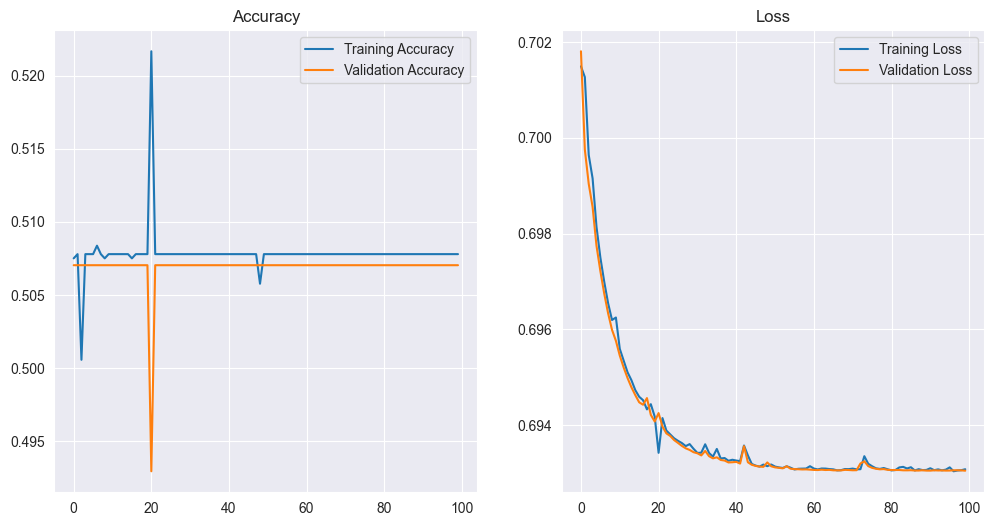

In [40]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

New ResNet

In [48]:
# Load the ResNet50 model pre-trained on ImageNet
# Exclude the top fully connected layers using include_top=False
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False


# Create a new model on top of the ResNet50 base
model = Sequential([
    base_model,
    MaxPooling2D(pool_size=2, strides=2),  # Flatten the feature maps to a vector
    Flatten(),
    Dense(256, activation='relu'),  # Add a dense layer with 256 units
    Dropout(0.3),  # Dropout for regularization
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.0001, weight_decay=0.01),
    loss=CategoricalCrossentropy(),      # Use categorical crossentropy for binary classification
    metrics=['accuracy']                 # Track accuracy during training
)

# Display the model summary
model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 2, 2, 2048)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_22 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                     

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_oralcancer_model1.keras', save_best_only=True, monitor='val_loss')

history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
55/55 [==============================] - 63s 994ms/step - loss: 0.9141 - accuracy: 0.5142 - val_loss: 0.7164 - val_accuracy: 0.4950
Epoch 2/100
55/55 [==============================] - 52s 946ms/step - loss: 0.7367 - accuracy: 0.5376 - val_loss: 0.7143 - val_accuracy: 0.5020
Epoch 3/100
55/55 [==============================] - 52s 940ms/step - loss: 0.6865 - accuracy: 0.5650 - val_loss: 0.7034 - val_accuracy: 0.5000
Epoch 4/100
55/55 [==============================] - 53s 958ms/step - loss: 0.6714 - accuracy: 0.5806 - val_loss: 0.7009 - val_accuracy: 0.4920
Epoch 5/100
55/55 [==============================] - 52s 956ms/step - loss: 0.6621 - accuracy: 0.6072 - val_loss: 0.6674 - val_accuracy: 0.5855
Epoch 6/100
55/55 [==============================] - 50s 919ms/step - loss: 0.6697 - accuracy: 0.5754 - val_loss: 0.6750 - val_accuracy: 0.5352
Epoch 7/100
55/55 [==============================] - 52s 951ms/step - loss: 0.6566 - accuracy: 0.5942 - val_loss: 0.6668 - val_accuracy:

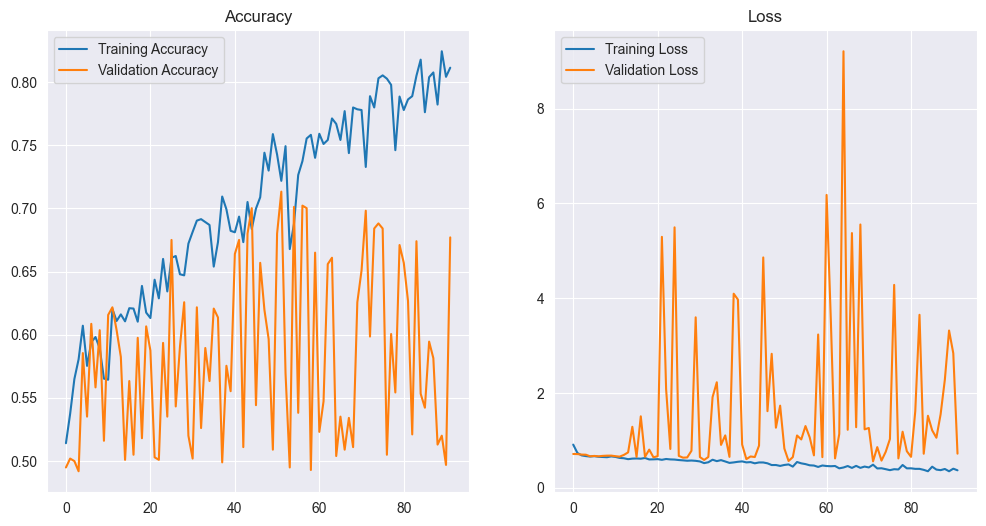

In [50]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [60]:
model = load_model('resnet_oralcancer_model1.keras')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 2, 2, 2048)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_22 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                     

In [61]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 [==============================] - 5s 245ms/step - loss: 0.6000 - accuracy: 0.7367
Test Loss: 0.5999942421913147
Test Accuracy: 0.7367346882820129


In [54]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_oralcancer_model1.keras', save_best_only=True, monitor='val_loss')

history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
55/55 [==============================] - 67s 1s/step - loss: 0.4160 - accuracy: 0.7839 - val_loss: 3.6072 - val_accuracy: 0.5664
Epoch 2/100
55/55 [==============================] - 63s 1s/step - loss: 0.4067 - accuracy: 0.7923 - val_loss: 0.6043 - val_accuracy: 0.7203
Epoch 3/100
55/55 [==============================] - 57s 1s/step - loss: 0.4657 - accuracy: 0.7643 - val_loss: 0.6395 - val_accuracy: 0.6087
Epoch 4/100
55/55 [==============================] - 57s 1s/step - loss: 0.4217 - accuracy: 0.7735 - val_loss: 2.3434 - val_accuracy: 0.6016
Epoch 5/100
55/55 [==============================] - 57s 1s/step - loss: 0.3821 - accuracy: 0.7978 - val_loss: 6.0162 - val_accuracy: 0.5080
Epoch 6/100
55/55 [==============================] - 57s 1s/step - loss: 0.3884 - accuracy: 0.8044 - val_loss: 0.7046 - val_accuracy: 0.7193
Epoch 7/100
55/55 [==============================] - 57s 1s/step - loss: 0.3614 - accuracy: 0.8180 - val_loss: 8.2212 - val_accuracy: 0.5302
Epoch 8/100
5

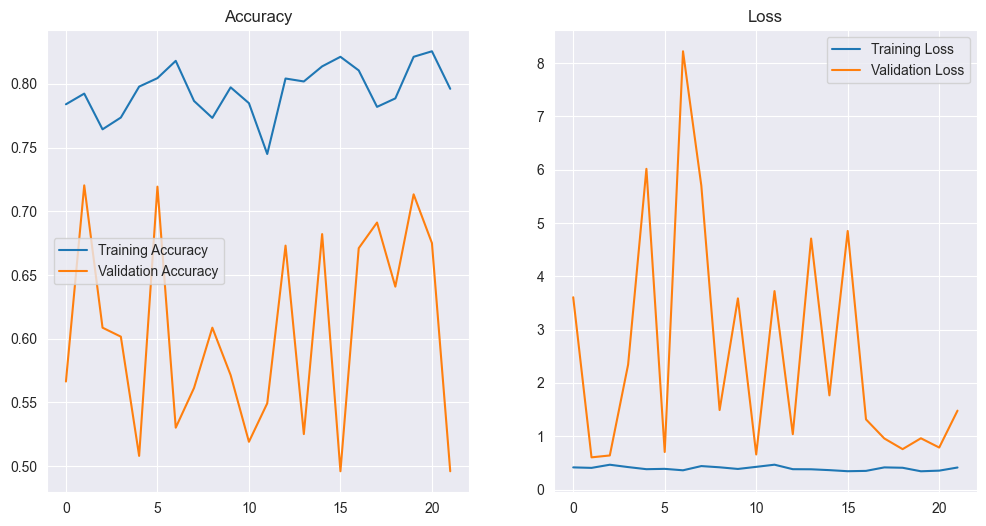

In [55]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [62]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile the model with a small learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_oralcancer_model11.keras', save_best_only=True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6)

# Train the model
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/100
55/55 [==============================] - 65s 1s/step - loss: 0.3520 - accuracy: 0.8172 - val_loss: 0.8850 - val_accuracy: 0.7022 - lr: 1.0000e-05
Epoch 2/100
55/55 [==============================] - 55s 1s/step - loss: 0.3245 - accuracy: 0.8287 - val_loss: 0.8772 - val_accuracy: 0.7042 - lr: 1.0000e-05
Epoch 3/100
55/55 [==============================] - 56s 1s/step - loss: 0.3029 - accuracy: 0.8382 - val_loss: 0.8125 - val_accuracy: 0.7455 - lr: 1.0000e-05
Epoch 4/100
55/55 [==============================] - 55s 994ms/step - loss: 0.3117 - accuracy: 0.8359 - val_loss: 0.7199 - val_accuracy: 0.6781 - lr: 1.0000e-05
Epoch 5/100
55/55 [==============================] - 53s 961ms/step - loss: 0.3014 - accuracy: 0.8423 - val_loss: 0.7419 - val_accuracy: 0.7012 - lr: 1.0000e-05
Epoch 6/100
55/55 [==============================] - 53s 962ms/step - loss: 0.2852 - accuracy: 0.8469 - val_loss: 0.7846 - val_accuracy: 0.7465 - lr: 1.0000e-05
Epoch 7/100
55/55 [========================

In [64]:
model = load_model('resnet_oralcancer_model11.keras')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 2, 2, 2048)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_22 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                     

In [65]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 [==============================] - 5s 246ms/step - loss: 0.6925 - accuracy: 0.7000
Test Loss: 0.6924569010734558
Test Accuracy: 0.699999988079071


In [66]:
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False

fine tune base model

In [79]:
# Create a new model on top of the ResNet50 base
model = Sequential([
    base_model,
    MaxPooling2D(pool_size=2, strides=2),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),  # Batch Normalization for stability
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # More neurons and L2 regularization
    Dropout(0.4),  # Increased dropout rate
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(2, activation='softmax')  # Output layer for binary classification
])

# Compile the model
model.compile(
    optimizer=AdamW(learning_rate=0.00001, weight_decay=0.01),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

Epoch 1/10
55/55 [==============================] - 80s 1s/step - loss: 7.4168 - accuracy: 0.5994 - val_loss: 9.2889 - val_accuracy: 0.5070 - lr: 1.0000e-05
Epoch 2/10
55/55 [==============================] - 62s 1s/step - loss: 7.1956 - accuracy: 0.6150 - val_loss: 7.5487 - val_accuracy: 0.5191 - lr: 1.0000e-05
Epoch 3/10
55/55 [==============================] - 60s 1s/step - loss: 7.0527 - accuracy: 0.6514 - val_loss: 7.1450 - val_accuracy: 0.5423 - lr: 1.0000e-05
Epoch 4/10
55/55 [==============================] - 61s 1s/step - loss: 6.9366 - accuracy: 0.6502 - val_loss: 6.9293 - val_accuracy: 0.5795 - lr: 1.0000e-05
Epoch 5/10
55/55 [==============================] - 64s 1s/step - loss: 6.8199 - accuracy: 0.6681 - val_loss: 6.7832 - val_accuracy: 0.6227 - lr: 1.0000e-05
Epoch 6/10
55/55 [==============================] - 67s 1s/step - loss: 6.7198 - accuracy: 0.6719 - val_loss: 6.6852 - val_accuracy: 0.6338 - lr: 1.0000e-05
Epoch 7/10
55/55 [==============================] - 62s 1s

In [83]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('resnet_oralcancer_model11.keras', save_best_only=True, monitor='val_loss')

# Fit the model
history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/100
55/55 [==============================] - 67s 1s/step - loss: 6.1965 - accuracy: 0.6967 - val_loss: 6.5869 - val_accuracy: 0.5352 - lr: 1.0000e-05
Epoch 2/100
55/55 [==============================] - 59s 1s/step - loss: 6.1066 - accuracy: 0.6990 - val_loss: 6.2720 - val_accuracy: 0.5976 - lr: 1.0000e-05
Epoch 3/100
55/55 [==============================] - 59s 1s/step - loss: 6.0074 - accuracy: 0.7111 - val_loss: 6.2739 - val_accuracy: 0.5483 - lr: 1.0000e-05
Epoch 4/100
55/55 [==============================] - 57s 1s/step - loss: 5.9068 - accuracy: 0.7189 - val_loss: 6.4337 - val_accuracy: 0.5070 - lr: 1.0000e-05
Epoch 5/100
55/55 [==============================] - 59s 1s/step - loss: 5.8106 - accuracy: 0.7224 - val_loss: 6.2930 - val_accuracy: 0.5322 - lr: 1.0000e-05
Epoch 6/100
55/55 [==============================] - 66s 1s/step - loss: 5.7177 - accuracy: 0.7354 - val_loss: 6.2625 - val_accuracy: 0.5372 - lr: 1.0000e-05
Epoch 7/100
55/55 [==============================] -

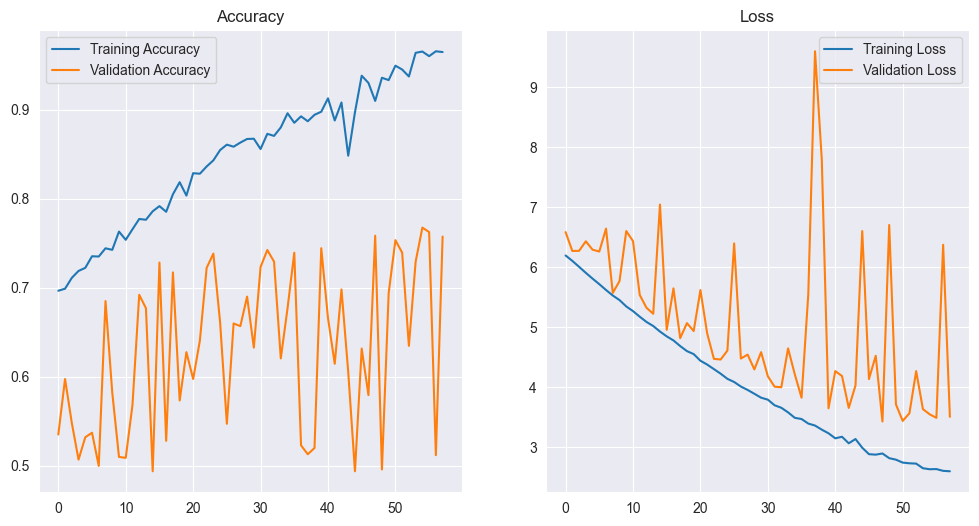

In [84]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [85]:
model = load_model('resnet_oralcancer_model11.keras')
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 2, 2, 2048)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_17 (Ba  (None, 2, 2, 2048)        8192      
 tchNormalization)                                               
                                                                 
 flatten_14 (Flatten)        (None, 8192)              0         
                                                                 
 dense_52 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_48 (Dropout)        (None, 256)             

In [86]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

16/16 [==============================] - 7s 295ms/step - loss: 3.4505 - accuracy: 0.7694
Test Loss: 3.4504847526550293
Test Accuracy: 0.7693877816200256


16/16 [==============================] - 6s 274ms/step


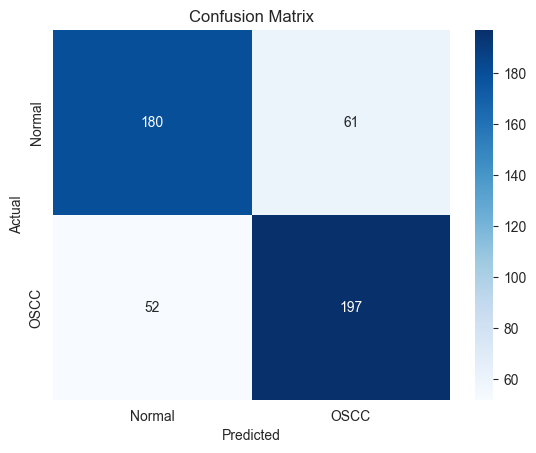

In [87]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()